# Graph Neural Network Tutorial

## What is a Graph Convolutional Network Layer?
Let's start with creating an example graph

In [1]:
# loosely adapted from https://dilinikarunarathna.medium.com/introduction-to-graph-convolutional-networks-gcn-2235ed69875d
# and based on this https://tkipf.github.io/graph-convolutional-networks/
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# do not show warnings for adjacency matrix
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

G = nx.Graph()
# our example graph consists of 4 nodes with 2-dimensional features
G.add_nodes_from(
    [
        (0, {"x": [-1.3, 2.2]}),
        (1, {"x": [0.6, -1.1]}),
        (2, {"x": [2.0, 1.4]}),
        (3, {"x": [5.1, 1.2]}),
    ]
)
# create the edges
edge_list = [(0, 2), (1, 2), (1, 3), (2, 3)]
G.add_edges_from(edge_list)

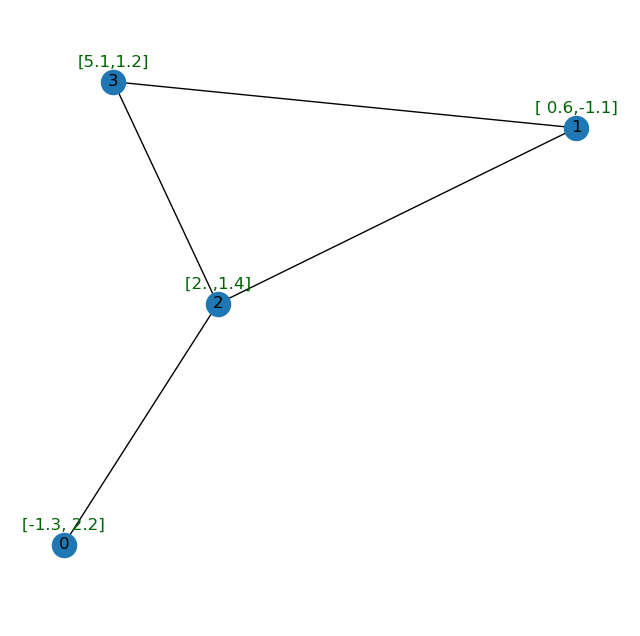

In [2]:
from .utils import draw_graph_with_attributes

pos = nx.spring_layout(G)
draw_graph_with_attributes(G, pos=pos)

### Adjacency Matrix
How do we model the structure of such a graph, i.e. which nodes are connected?
We use an _adjacency matrix_

In [3]:
A = nx.adjacency_matrix(G).toarray()
A

array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 1, 0, 1],
       [0, 1, 1, 0]])

Since our graph is not directed the adjacency matrix is symmetric.
Because every edge from _x_ to _y_ is also an edge from _y_ to _x_.
The adjacency matrix shows us which nodes are connected via the rows and columns.
So in column 0 we see to which nodes our node 0 is connected.
And as we saw in picture, it is only connected to node 2, which why the value of `A[0][2] = 1` and everything else is 0

### Feature Matrix
As we've seen before each node in our graph has a feature set.
We call this our feature matrix.

In [4]:
props = nx.get_node_attributes(G, "x")
X = np.array([props[i] for i in range(len(G))])
X

array([[-1.3,  2.2],
       [ 0.6, -1.1],
       [ 2. ,  1.4],
       [ 5.1,  1.2]])

Again we see for example that node 2 has the features `[2.,1.4]` (yes the features do not really mean anything in this example)

### What does a GCN Layer do?
As input they take features of every node in in the form of a feature matrix of the form $N \times M$,
with $N$ being the number of nodes and $M$ being the dimensionality of the features.

In [5]:
X.shape

(4, 2)

Since we have 4 nodes and our features have the dimensionality of 2

Another input for the GCN is the structural information.
We have already seen this in form of the adjacency matrix $A$

The node-level output $Z$ is a $N \times F$ feature matrix,
with $F$ being the number of output features.

We can then write our neural network layers as

$\Large H^{(l+1)}=f(H^{(l)},A)$

with $H^{(0)}=X$ and $H^{(L)}=Z$, with $Z$ again being the output and $L$ the number of layers.

Specific models then only differ in the function $f(\cdot,\cdot)$.

A simple layer-wise propagation rule would be for example:

$\Large f(H^{(l)}, A)=\sigma (AH^{(l)}W^{(l)})$

where
 - $W^{(l)}$ is the weight matrix for our $l$-th layer

 - $\sigma(\cdot)$ is a non-linear activation function



In [6]:
W = np.random.rand(2, 2)
W

array([[0.87664635, 0.84573406],
       [0.88540444, 0.60708144]])

Let's define a GCN Layer, ignoring the activation for now

In [7]:
def gcn_layer(H: np.ndarray, A: np.ndarray, W: np.ndarray):
    return A @ H @ W

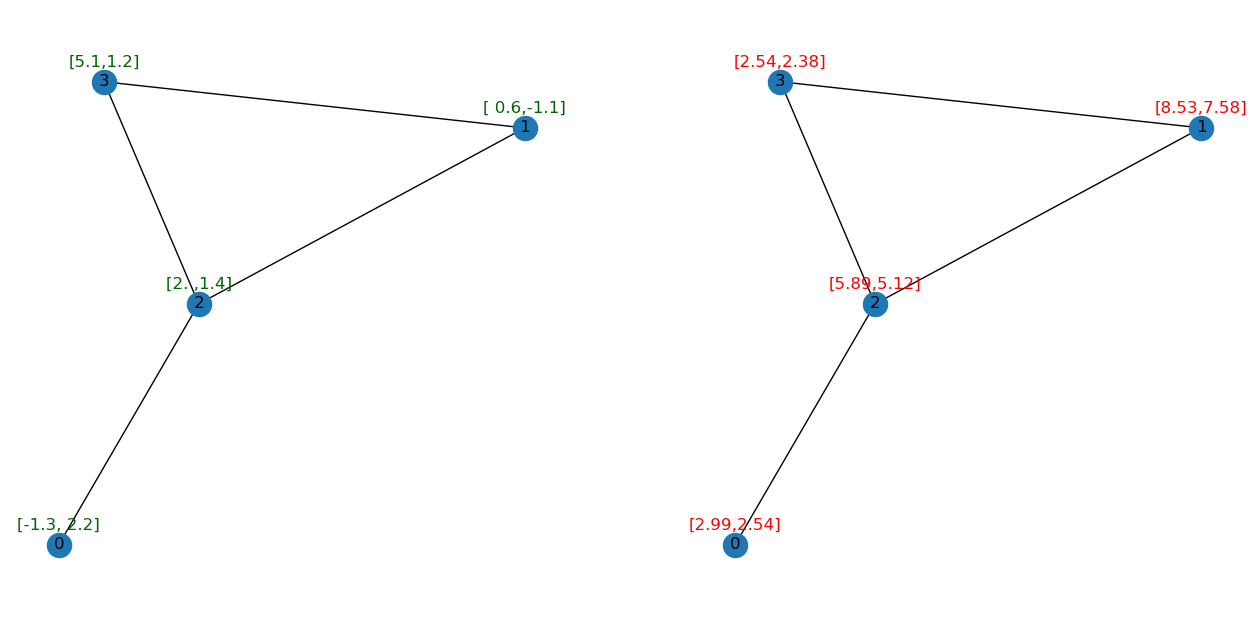

In [8]:
from typing import Callable


def features_and_adjacency(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    """Get features and adjacency matrix from graph."""
    props = nx.get_node_attributes(G, "x")
    X = np.array([props[i] for i in range(len(G))])
    A = nx.adjacency_matrix(G).toarray()
    return X, A


def feature_array_to_dict(X: np.ndarray):
    """Create feature dictionary"""
    return {node_id: {"x": x} for node_id, x in enumerate(X)}


def propagate_and_draw(
    G: nx.Graph,
    X: np.ndarray,
    A: np.ndarray,
    W: np.ndarray,
    gcn_layer_func: Callable,
    pos: Dict[int, np.ndarray] = None,
    figsize: Tuple[int, int] = (16, 8),
):
    """Apply propagation rule and draw before and after"""
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    if pos is None:
        pos = nx.spring_layout(G)
    draw_graph_with_attributes(G, pos=pos, ax=ax[0])
    G_1 = G.copy()
    H_1 = gcn_layer_func(X, A, W)
    nx.set_node_attributes(G_1, feature_array_to_dict(H_1))
    draw_graph_with_attributes(G_1, pos=pos, ax=ax[1], font_color="red")


X, A = features_and_adjacency(G)
propagate_and_draw(G, X, A, W, gcn_layer, pos=pos)

This is simple enough.
However this propagation rule has some problems.


### Normalization
For example we would expect the features of a node to have some effect on the output of the node itself.
However....

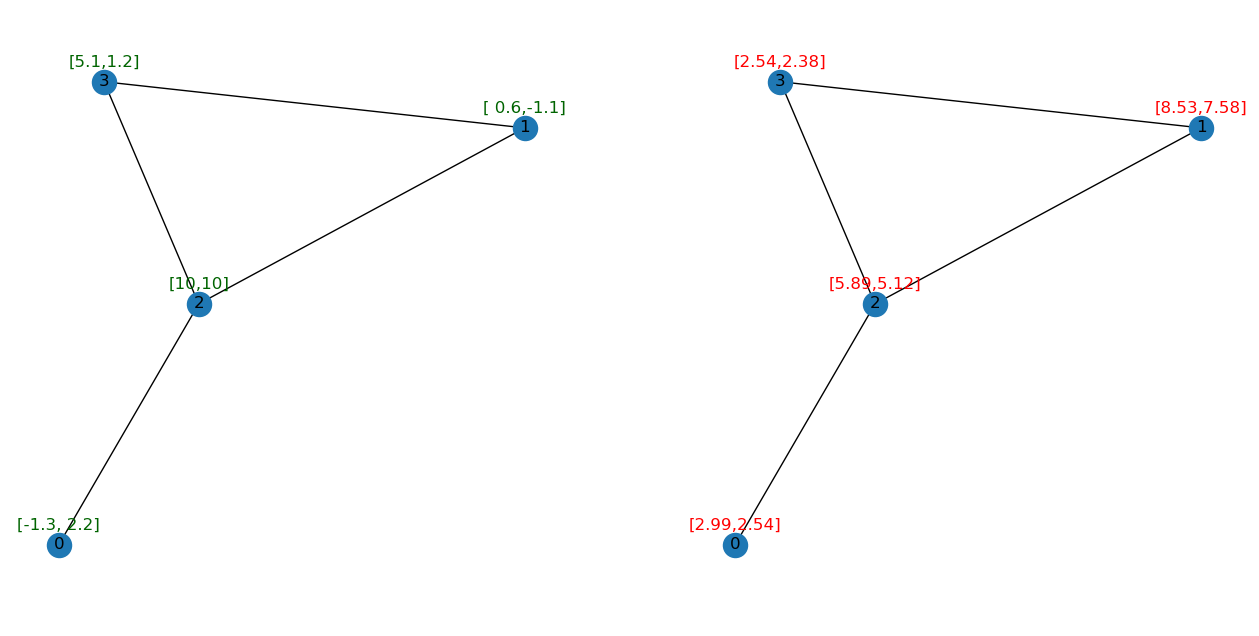

In [9]:
nx.set_node_attributes(G, {2: {"x": [10, 10]}})
propagate_and_draw(G, X, A, W, gcn_layer, pos=pos)

The large values of node `2` affect only it's neighbors.
Why is that?
Because we do not have any self-loops in our adjacency matrix!
This means nodes don't propagate their features to themselves.
This can be easily fixed.

In [10]:
I = np.eye(4, 4)
I

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [11]:
A_tilde = A + I
A_tilde

array([[1., 0., 1., 0.],
       [0., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 1., 1., 1.]])

Now $\tilde{A}$ is the adjacency matrix which contains self-loops!
Let's try our example again.

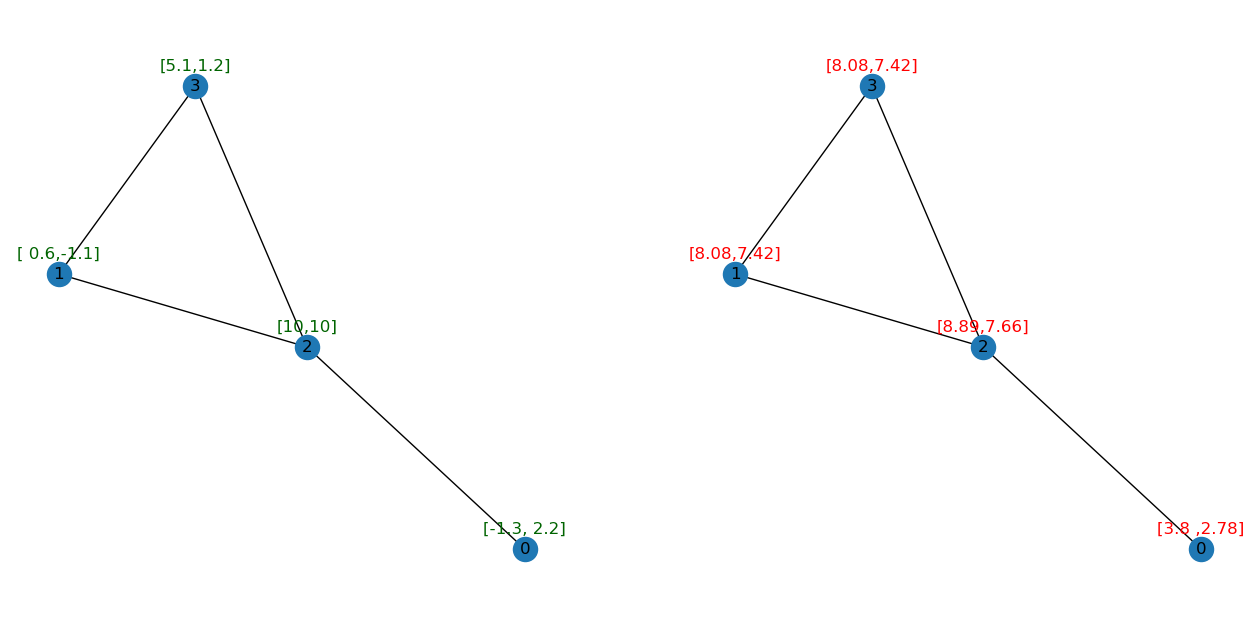

In [12]:
propagate_and_draw(G, X, A_tilde, W, gcn_layer)

The second problem is that $A$ is not normalized, which changes the scale of the features in the multiplication process.

This will make it hard to optimize and the more layers we have the larger the values will be.

We can fix this by making sure that all rows in $A$ sum to one.

To do this we need the node degrees.
A node degree is simply the number of neighbors of a node.

In [13]:
degree_dict = {node_id: degree for node_id, degree in nx.degree(G)}
degree_dict

{0: 1, 1: 2, 2: 3, 3: 2}

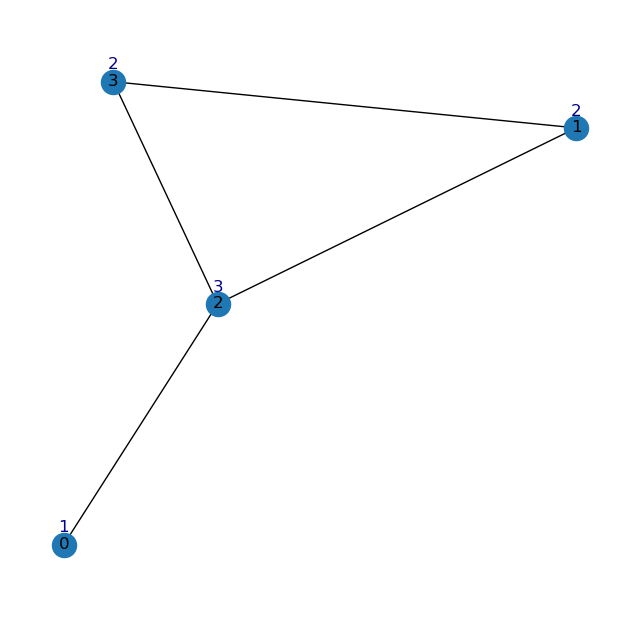

In [14]:
draw_graph_with_attributes(
    G, pos=pos, props=degree_dict, y_nudge=0.06, font_color="darkblue"
)

In [15]:
degree_dict = nx.degree(G)
# + 1 to add self-loops into degree
D = np.array([degree_dict[i] + 1 for i in range(len(G))])
D = D * I  # create diagonal degree by point-wise multiplication
D

array([[2., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 4., 0.],
       [0., 0., 0., 3.]])

Now we have the diagonal degree matrix $\tilde{D}$ (which is the diagonal degree matrix of $\tilde{A}$, which was $\tilde{A}=A+I$).

To normalize $A$ we now have to average the neighboring node features.

This can be expressed as $D^{-1}A$

In [16]:
from numpy.linalg import matrix_power

D_power_minus_1 = matrix_power(D, -1)
D_power_minus_1

array([[0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.25      , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [17]:
D_power_minus_1 @ A_tilde

array([[0.5       , 0.        , 0.5       , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.        , 0.33333333, 0.33333333, 0.33333333]])

As we can see this now sums to `1` for each row

One problem with this is that this does not take into account the connectivity of the neighbors.

We can fix this by performing not only row-wise but column-wise normalization as well:

$\Large D^{\frac{1}{2}}AD^{\frac{1}{2}}$

(More detailed explanation about normalization [here](https://math.stackexchange.com/a/3284214))

In [18]:
import scipy

D_power_minus_1_2 = scipy.linalg.fractional_matrix_power(D, -1 / 2)
D_power_minus_1_2

array([[0.70710678, 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.57735027]])

In [19]:
D_power_minus_1_2 @ A_tilde @ D_power_minus_1_2

array([[0.5       , 0.        , 0.35355339, 0.        ],
       [0.        , 0.33333333, 0.28867513, 0.33333333],
       [0.35355339, 0.28867513, 0.25      , 0.28867513],
       [0.        , 0.33333333, 0.28867513, 0.33333333]])

Now we have everything we need to understand the propagation rule introduced by [Kipf & Welling in their 2017 ICLR paper](https://arxiv.org/pdf/1609.02907.pdf):

$\Huge f(H^{(l)},A)= \sigma(\tilde{D}^{\frac{1}{2}}\tilde{A}\tilde{D}^{\frac{1}{2}}H^{(l)}W^{(l)})$

### Everybody was kung fu fighting 🥋🤼‍♀️🥊

(Well, actually it's karate)

Now comes the graph that probably everybody who works with graphs
has seen: [Zachary's Karate Club](https://www.journals.uchicago.edu/doi/10.1086/jar.33.4.3629752).
It's a social network graph of a university karate club used for community detection. More info can be found e.g. on [Wikipedia](https://en.wikipedia.org/wiki/Zachary's_karate_club#Network_description)

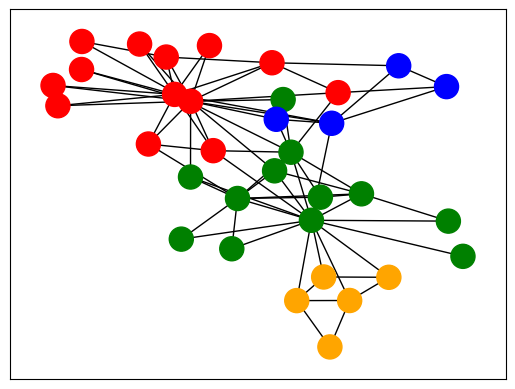

In [20]:
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx

dataset = KarateClub()
data_nx = to_networkx(dataset.data)
color_list = ["red", "green", "blue", "orange"]
nx.draw_networkx(
    data_nx.to_undirected(),
    with_labels=False,
    node_color=[color_list[community] for community in dataset.data.y],
)

The dataset in [PyTorch-Geometric](https://github.com/pyg-team/pytorch_geometric) comes with the task to perform community detection.
In the plot you can see the perfect assignment shown by the node colors.

In [21]:
data = dataset.data
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

This dataset does not contain any node features, which is why `x` is set to the identity matrix.

In [44]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

Now we show how powerful GCNs are 💪.
It has been shown, that even untrained GCNs already perform remarkably well.
So let's try this out on our Karate Club example.

Following the appendix of Kipf & Welling's GCN paper we create a 3 layer GCN which amounts to the following:

$ \Large Z = \textrm{tanh}(\hat{A} \; \textrm{tanh}(\hat{A} \; \textrm{tanh}(\hat{A}XW^{(0)}) W^{(1)}) W^{(2)})) $

here $\Large \hat{A} = \tilde{D}^{\frac{1}{2}}\tilde{A}\tilde{D}^{\frac{1}{2}}$ to make the notation more concise

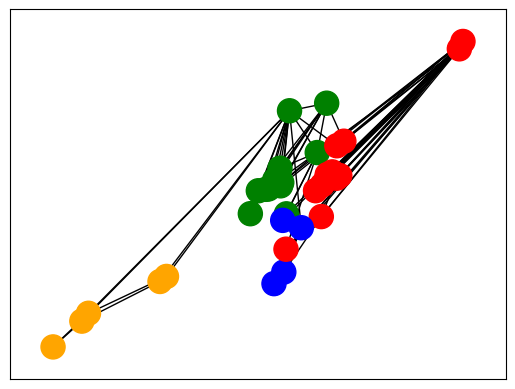

In [22]:
import torch

# to spare me some typing we simply load the GCNConv layer from torch-geometric
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # the layers come without activation so here we use tanh
        x = self.conv1(x, edge_index).tanh()
        x = self.conv2(x, edge_index).tanh()
        x = self.conv3(x, edge_index).tanh()
        return x


# following the paper we set the size of the hidden layers to 4
# and set the output to 2 for simple visualization
model = GCN(dataset.num_features, 4, 2)
pos = model(data.x, data.edge_index).detach().cpu().numpy()
nx.draw_networkx(
    data_nx.to_undirected(),
    pos=pos,
    with_labels=False,
    node_color=[color_list[community] for community in data.y],
)

The 3-layer GCN convolves the 3 hop neighborhood of every node.
And as we can see: the node embeddings roughly resemble the community-structure of the graph.
Even though we used randomly initialized weights and did not train our model!

### Community detection in a citation graph
Let's look at slightly bigger, but equally popular example.
The [Cora dataset](https://arxiv.org/pdf/1603.08861.pdf) contains a citation graph, where nodes represent papers and edges represent citations.
All papers belong to a specific topic and again the task is to predict this class.
The node features are one-hot encoded word-vectors describing the paper.

In [23]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

dataset = Planetoid("./data/Planetoid", "Cora", transform=T.NormalizeFeatures())
data = dataset.data
data_nx = to_networkx(dataset.data)
data_nx = data_nx.to_undirected()

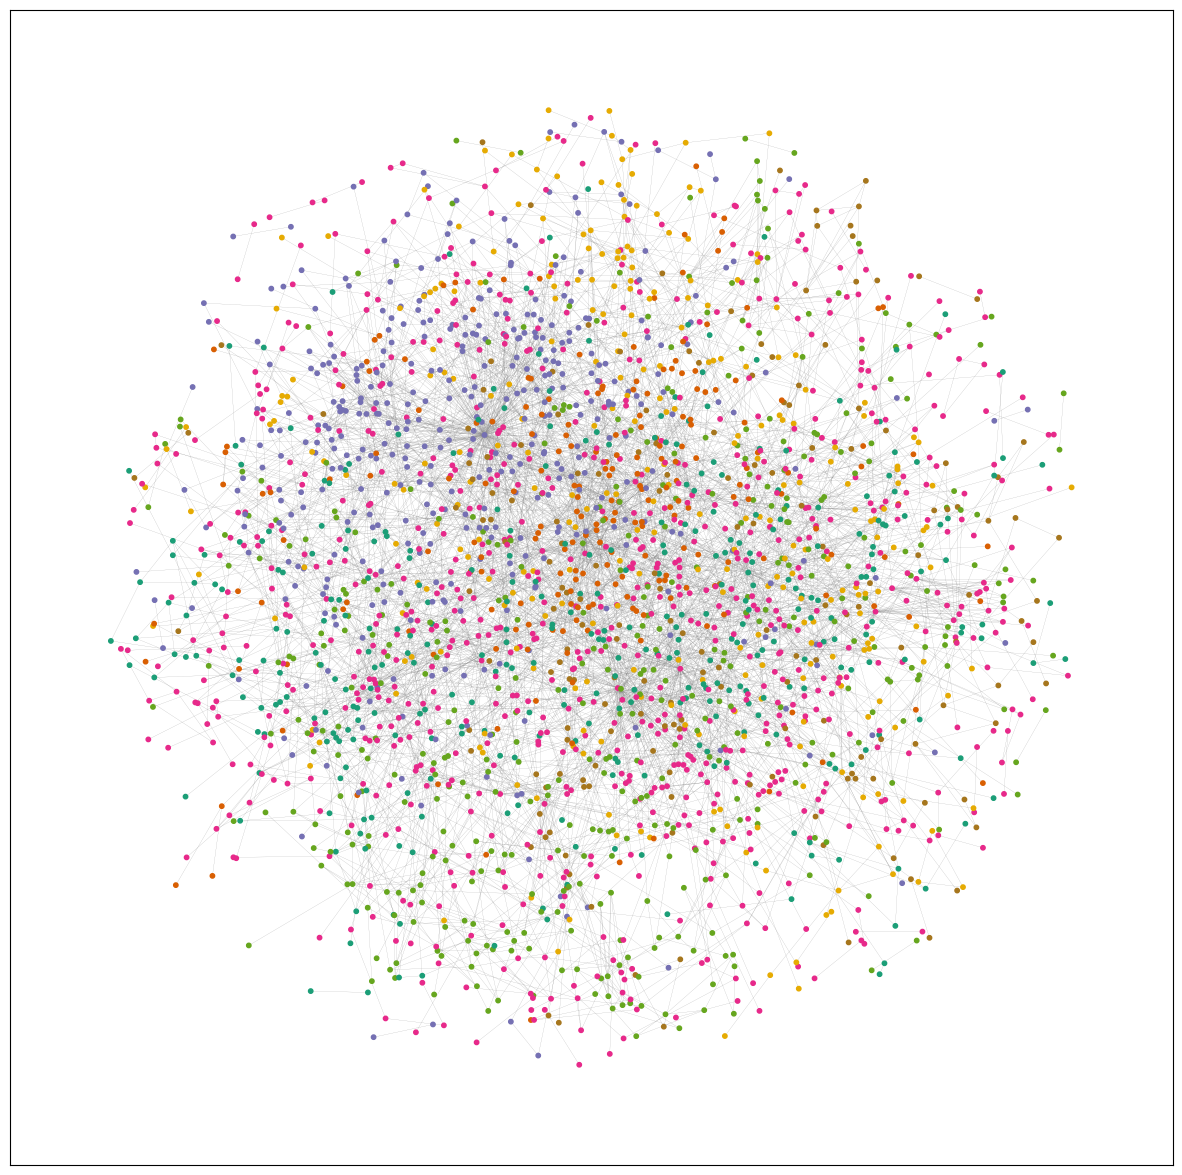

In [24]:
import matplotlib as mpl

color_list = list(mpl.colormaps["Dark2"].colors)[0 : dataset.num_classes]
pos = nx.spring_layout(data_nx, k=0.1)
plt.figure(1, figsize=(15, 15))
nx.draw_networkx(
    data_nx,
    pos=pos,
    with_labels=False,
    node_size=10,
    edge_color="gray",
    width=0.1,
    node_color=[color_list[community] for community in dataset.data.y],
)

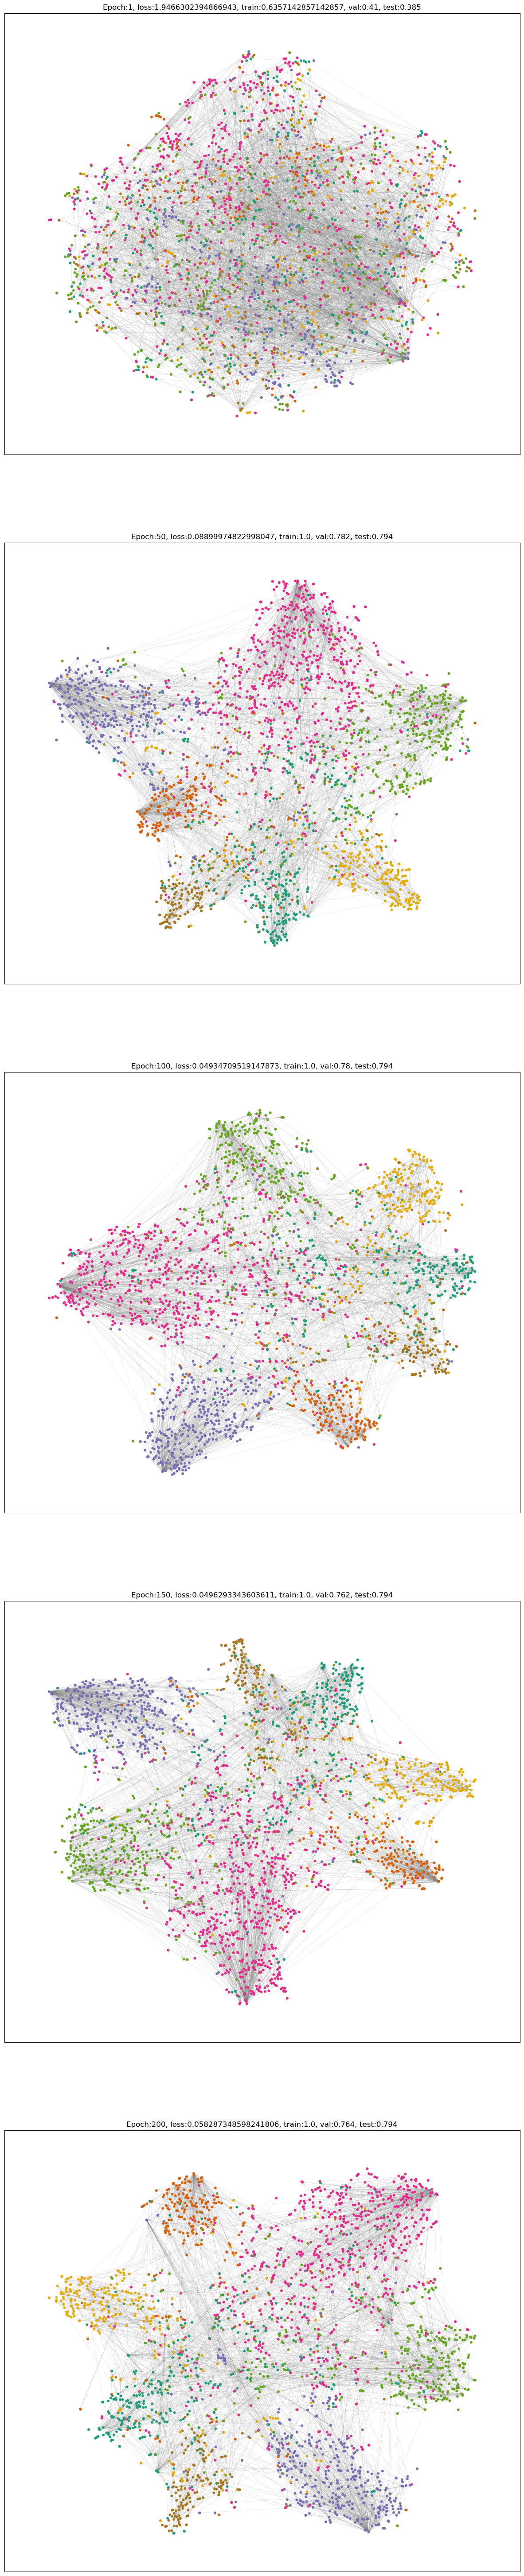

In [45]:
from typing import List
import torch.nn.functional as F
from sklearn.manifold import TSNE

# adapted from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gcn.py
class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x: torch.FloatTensor, edge_index: torch.LongTensor):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss), out


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


def draw(out: torch.FloatTensor, title: str, color_list: List[Tuple[float, float, float]], classes: torch.LongTensor, ax: mpl.axes.Axes):
    # get 2-dimensional view of node embeddings
    pos = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=30
    ).fit_transform(out.detach().cpu().numpy())
    ax.set_title(title)
    nx.draw_networkx(
        data_nx,
        pos=pos,
        with_labels=False,
        node_size=10,
        edge_color="gray",
        width=0.1,
        node_color=[color_list[community] for community in classes],
        ax=ax,
    )
    
model = GCN(dataset.num_features, 16, dataset.num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(
    [
        dict(params=model.conv1.parameters(), weight_decay=5e-4),
        dict(params=model.conv2.parameters(), weight_decay=0),
    ],
    lr=0.01,
)  # Only perform weight-decay on first convolution.


fig, ax = plt.subplots(5, 1, figsize=(15, 15 * 5))
ax_id = 0
best_val_acc = final_test_acc = 0
for epoch in range(1, 200 + 1):
    loss, out = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    if epoch in [1, 50, 100, 150, 200]:
        draw(
            out,
            f"Epoch:{epoch}, loss:{loss}, train:{train_acc}, val:{val_acc}, test:{test_acc}",
            color_list,
            data.y,
            ax[ax_id],
        )
        ax_id += 1

## What next? A peek into other types of layers
The types of graphs we have seen until now were undirected and had a single type.
However in many cases we have we have graphs were directions matter and we have different edge types

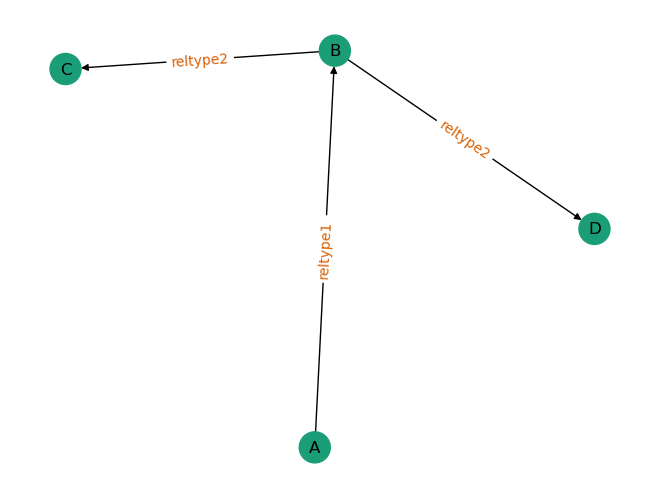

In [39]:
edges = [['A', 'B'], ['B', 'C'], ['B', 'D']]
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=[color_list[0] for _ in G],
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={('A', 'B'): 'reltype1', 
                 ('B', 'C'): 'reltype2', 
                 ('B', 'D'): 'reltype2'},
    font_color=color_list[1]
)
plt.axis('off')
plt.show()

Let's take a slightly different look at the previously introduced GCN layer:

$\Large h_{v_{i}}^{(l+1)} = \sigma \left(\sum_{j} \frac{1}{c_{ij}} h_{v_{j}}^{(l)} W^{(l)}\right)$

This is the same equation as before just in vector-form.

- $\large j$ indexes the neighboring nodes of $\large v_{i}$
- $\large c_{ij}$ is a normalization constant for the edge $\large (v_i,v_j)$ coming from the symmetrically normalized adjacency matrix

What we can see is that all relations would be treated equally in such a layer.
To address this and adapt GCN for relational (directed and labeled) multi-graphs [RGCN](https://arxiv.org/pdf/1703.06103.pdf) was invented by Schlitkrull et. al.

The propagation rule is the following:

$\Huge h_{{i}}^{(l+1)} = \sigma \left(\sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_{i}^{r}} \frac{1}{c_{i,r}} W^{(l)}_{r} h^{(l)}_{j} + W_{0}^{(l)} h_{i}^{(l)}\right)$

where
- $\Large \mathcal{N}_{i}^{r}$ denotes the set of neighbor indices of $\large i$ under the relation $\large r \in \mathcal{R}$
- $\Large c_{i,r}$ is specific normalization constant which can be learned or chosen in advance
- we have a relation-specific transformation $\Large W_{r}$
- and a special relation type for self-connection $\Large W_{0}$

<img src="rgcn.png" width="800">

An in-depth tutorial on Graph Attention Networks can be found [here](https://docs.dgl.ai/tutorials/models/1_gnn/9_gat.html)